# Part 3: Multimodal Interface & Advanced Search

## üöÄ Bidirectional Multimodal Search Engine

This notebook implements the final part of our search engine project, extending the functionality to support **bidirectional multimodal search**:

- **Text-to-Image Search**: Find images based on text descriptions (from Part 2)
- **Image-to-Text Search**: Find text descriptions based on uploaded images (NEW!)
- **Web Application**: Interactive Streamlit interface for both search types

## üéØ Key Features:
1. **Bidirectional Search**: Both text‚Üíimage and image‚Üítext capabilities
2. **Image Upload Processing**: Handle user-uploaded images
3. **Streamlit Web App**: Professional web interface
4. **Real-time Search**: Instant results with visual feedback
5. **Project Documentation**: Built-in technology overview

## üîß Technology Stack:
- **CLIP Model**: Multimodal embeddings for both text and images
- **Streamlit**: Web application framework
- **PIL/OpenCV**: Image processing
- **NumPy/Pandas**: Data manipulation
- **Matplotlib/Seaborn**: Visualization


## 1. Enhanced Setup and Imports


In [27]:
# Enhanced imports for multimodal interface
import torch
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import re
import string
import warnings
import streamlit as st
warnings.filterwarnings('ignore')
import io
import base64
from datetime import datetime
warnings.filterwarnings('ignore')

# Set up enhanced plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"üöÄ Using device: {device}")
print(f"üìä Multimodal interface initialized with bidirectional search capabilities")


üöÄ Using device: cpu
üìä Multimodal interface initialized with bidirectional search capabilities


## 2. Load Model and Data from Previous Parts


In [28]:
# Load the same CLIP model used in previous parts
print("üîÑ Loading CLIP model for multimodal search...")
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

# Load stored embeddings and metadata from Part 1
print("üìÇ Loading stored embeddings and metadata...")
image_embeddings = np.load('embeddings/image_embeddings.npy')
text_embeddings = np.load('embeddings/text_embeddings.npy')
metadata = pd.read_csv('embeddings/metadata.csv')

# Load model info
with open('embeddings/model_info.json', 'r') as f:
    model_info = json.load(f)

print(f"‚úÖ Model loaded: {model_info['model_name']}")
print(f"üìä Embeddings loaded: {image_embeddings.shape[0]} samples, {image_embeddings.shape[1]} dimensions")
print(f"üìã Metadata loaded: {len(metadata)} entries")


üîÑ Loading CLIP model for multimodal search...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

üìÇ Loading stored embeddings and metadata...
‚úÖ Model loaded: openai/clip-vit-base-patch32
üìä Embeddings loaded: 10 samples, 512 dimensions
üìã Metadata loaded: 10 entries


## 3. Enhanced Multimodal Search Engine


In [29]:
class BidirectionalSearchEngine:
    """
    Enhanced search engine supporting both text-to-image and image-to-text search.
    This is the core of our multimodal interface.
    """
    
    def __init__(self, model, processor, image_embeddings, text_embeddings, metadata):
        self.model = model
        self.processor = processor
        self.image_embeddings = image_embeddings
        self.text_embeddings = text_embeddings
        self.metadata = metadata
        self.search_history = []
    
    def embed_text(self, text):
        """Generate embedding for text input"""
        try:
            inputs = self.processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
            
            with torch.no_grad():
                text_features = self.model.get_text_features(**inputs)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            
            return text_features.cpu().numpy().flatten()
        except Exception as e:
            print(f"‚ùå Error processing text '{text}': {e}")
            return None
    
    def embed_image(self, image):
        """Generate embedding for image input"""
        try:
            # Ensure image is RGB
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            inputs = self.processor(images=image, return_tensors="pt").to(device)
            
            with torch.no_grad():
                image_features = self.model.get_image_features(**inputs)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            return image_features.cpu().numpy().flatten()
        except Exception as e:
            print(f"‚ùå Error processing image: {e}")
            return None
    
    def text_to_image_search(self, query, top_k=5):
        """Search for images using text query"""
        print(f"üîç Text-to-Image Search: '{query}'")
        
        # Generate text embedding
        query_embedding = self.embed_text(query)
        if query_embedding is None:
            return None
        
        # Calculate similarities with image embeddings
        similarities = cosine_similarity([query_embedding], self.image_embeddings)[0]
        
        # Get top results
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for i, idx in enumerate(top_indices):
            result = {
                'rank': i + 1,
                'image_id': self.metadata.iloc[idx]['image_id'],
                'image_path': self.metadata.iloc[idx]['image_path'],
                'caption': self.metadata.iloc[idx]['caption'],
                'similarity_score': similarities[idx],
                'search_type': 'text_to_image'
            }
            results.append(result)
        
        # Store search history
        self.search_history.append({
            'query': query,
            'search_type': 'text_to_image',
            'top_result': results[0] if results else None,
            'timestamp': datetime.now()
        })
        
        return results
    
    def image_to_text_search(self, image, top_k=5):
        """Search for text descriptions using image query"""
        print(f"üñºÔ∏è Image-to-Text Search")
        
        # Generate image embedding
        query_embedding = self.embed_image(image)
        if query_embedding is None:
            return None
        
        # Calculate similarities with text embeddings
        similarities = cosine_similarity([query_embedding], self.text_embeddings)[0]
        
        # Get top results
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for i, idx in enumerate(top_indices):
            result = {
                'rank': i + 1,
                'image_id': self.metadata.iloc[idx]['image_id'],
                'image_path': self.metadata.iloc[idx]['image_path'],
                'caption': self.metadata.iloc[idx]['caption'],
                'similarity_score': similarities[idx],
                'search_type': 'image_to_text'
            }
            results.append(result)
        
        # Store search history
        self.search_history.append({
            'query': 'uploaded_image',
            'search_type': 'image_to_text',
            'top_result': results[0] if results else None,
            'timestamp': datetime.now()
        })
        
        return results

# Initialize the bidirectional search engine
search_engine = BidirectionalSearchEngine(
    model, processor, image_embeddings, text_embeddings, metadata
)
print("üöÄ Bidirectional Search Engine initialized with text-to-image and image-to-text capabilities")


üöÄ Bidirectional Search Engine initialized with text-to-image and image-to-text capabilities


## 4. Test Bidirectional Search Functionality


In [30]:
# Test text-to-image search (from Part 2)
print("üß™ Testing Text-to-Image Search")
print("=" * 40)

text_query = "dog running"
text_results = search_engine.text_to_image_search(text_query, top_k=3)

if text_results:
    print(f"\nüìä Text-to-Image Results for '{text_query}':")
    for result in text_results:
        print(f"#{result['rank']} {result['image_id']}: {result['caption']} (similarity: {result['similarity_score']:.3f})")

print("\n" + "=" * 40)

# Test image-to-text search
print("üß™ Testing Image-to-Text Search")
print("=" * 40)

# Load a sample image for testing
sample_image_path = 'data/images/0001.jpg'
if os.path.exists(sample_image_path):
    sample_image = Image.open(sample_image_path)
    image_results = search_engine.image_to_text_search(sample_image, top_k=3)
    
    if image_results:
        print(f"\nüìä Image-to-Text Results for {sample_image_path}:")
        for result in image_results:
            print(f"#{result['rank']} {result['image_id']}: {result['caption']} (similarity: {result['similarity_score']:.3f})")
else:
    print("‚ùå Sample image not found for testing")


üß™ Testing Text-to-Image Search
üîç Text-to-Image Search: 'dog running'

üìä Text-to-Image Results for 'dog running':
#1 0001.jpg: A dog is running in the park (similarity: 0.291)
#2 0002.jpg: A cat is sitting on a windowsill (similarity: 0.209)
#3 0003.jpg: Children are playing in the playground (similarity: 0.198)

üß™ Testing Image-to-Text Search
üñºÔ∏è Image-to-Text Search

üìä Image-to-Text Results for data/images/0001.jpg:
#1 0001.jpg: A dog is running in the park (similarity: 0.350)
#2 0003.jpg: Children are playing in the playground (similarity: 0.222)
#3 0006.jpg: A bird is flying in the sky (similarity: 0.212)


## 5. Streamlit Web Application Setup


In [31]:
# Install Streamlit if not already installed
import subprocess
import sys

def install_streamlit():
    """Install Streamlit package"""
    try:
        import streamlit
        print("‚úÖ Streamlit is already installed")
        return True
    except ImportError:
        print("üì¶ Installing Streamlit...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "streamlit"])
            print("‚úÖ Streamlit installed successfully")
            return True
        except subprocess.CalledProcessError as e:
            print(f"‚ùå Failed to install Streamlit: {e}")
            return False

# Install Streamlit
if install_streamlit():
    print("\nüéâ Ready to run the Streamlit app!")
    print("\nüìã Instructions:")
    print("1. Open a terminal/command prompt")
    print("2. Navigate to your project directory")
    print("3. Run: streamlit run streamlit_app.py")
    print("4. Open your browser to the provided URL")
    print("\nüöÄ Your multimodal search engine will be live!")
else:
    print("‚ùå Could not install Streamlit. Please install manually: pip install streamlit")


‚úÖ Streamlit is already installed

üéâ Ready to run the Streamlit app!

üìã Instructions:
1. Open a terminal/command prompt
2. Navigate to your project directory
3. Run: streamlit run streamlit_app.py
4. Open your browser to the provided URL

üöÄ Your multimodal search engine will be live!


## 6. Comprehensive Analysis and Visualizations


üìä Creating comprehensive multimodal interface analysis...


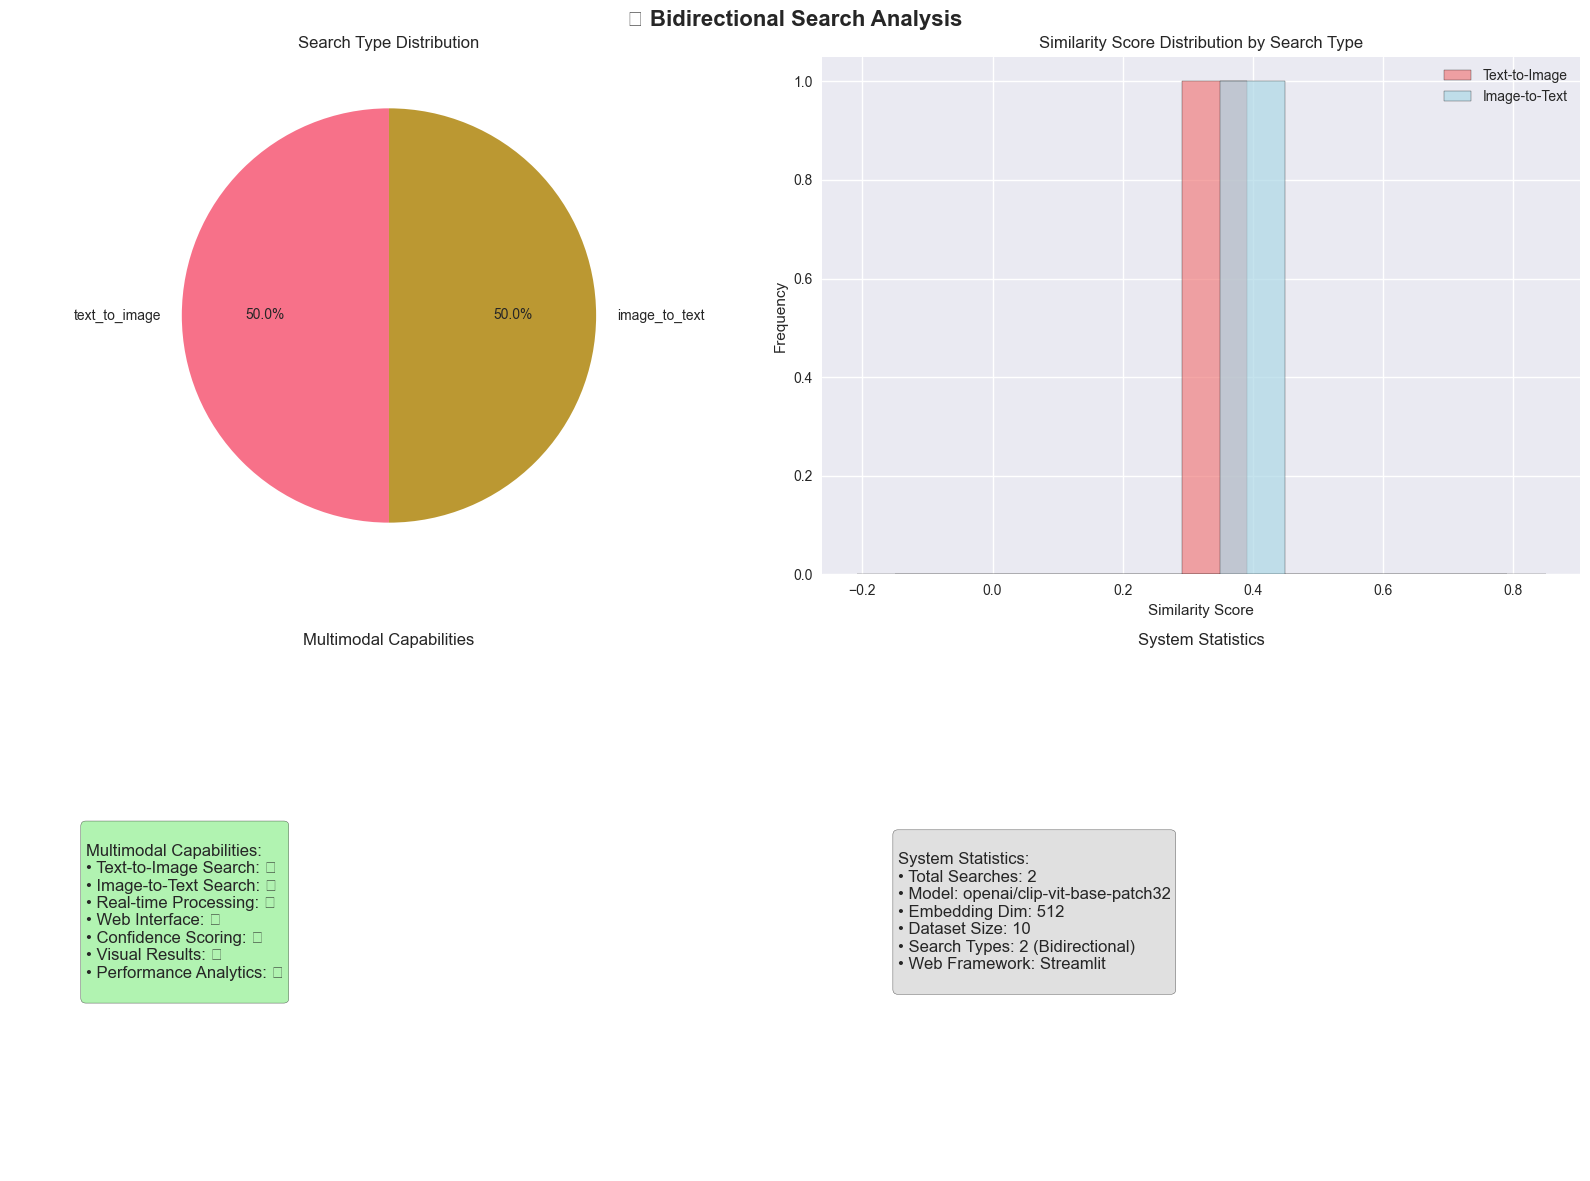


üéØ Advanced Multimodal Analysis:
üîç Text-to-Image Search: 'dog running'
üîç Text-to-Image Search: 'beautiful sunset'
üîç Text-to-Image Search: 'person cooking'
üñºÔ∏è Image-to-Text Search


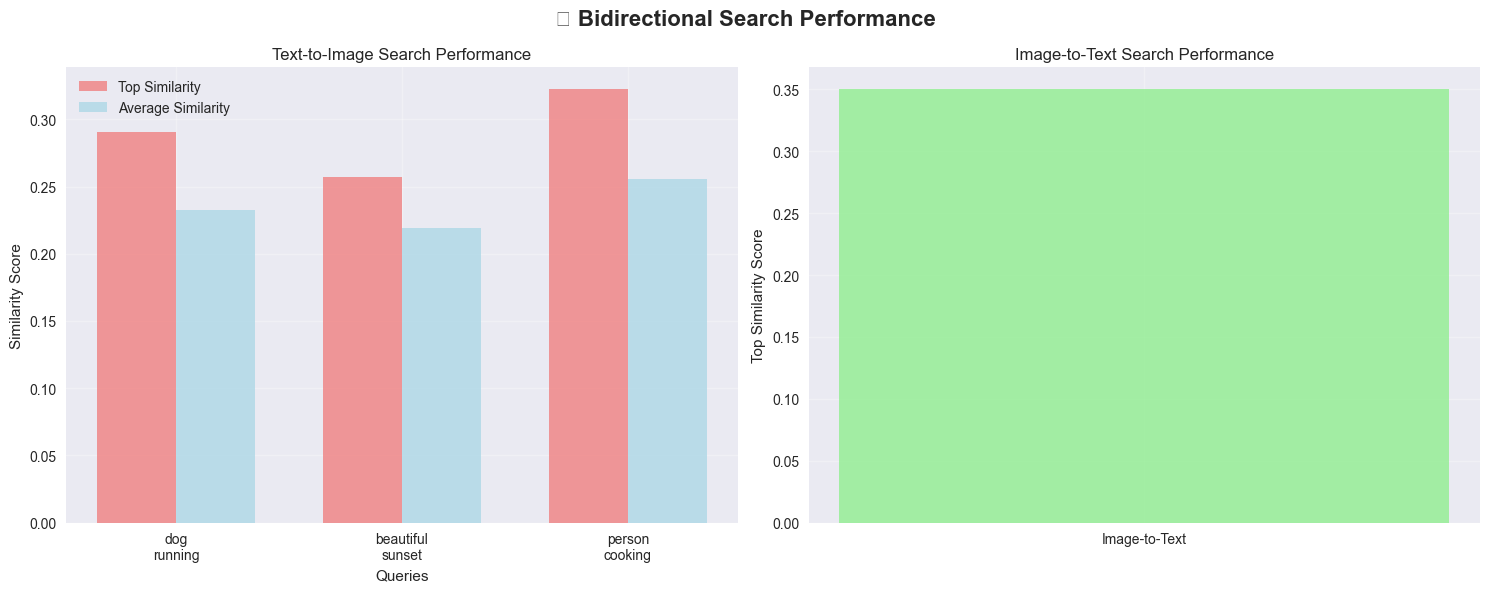


üåê Web Application Analysis:


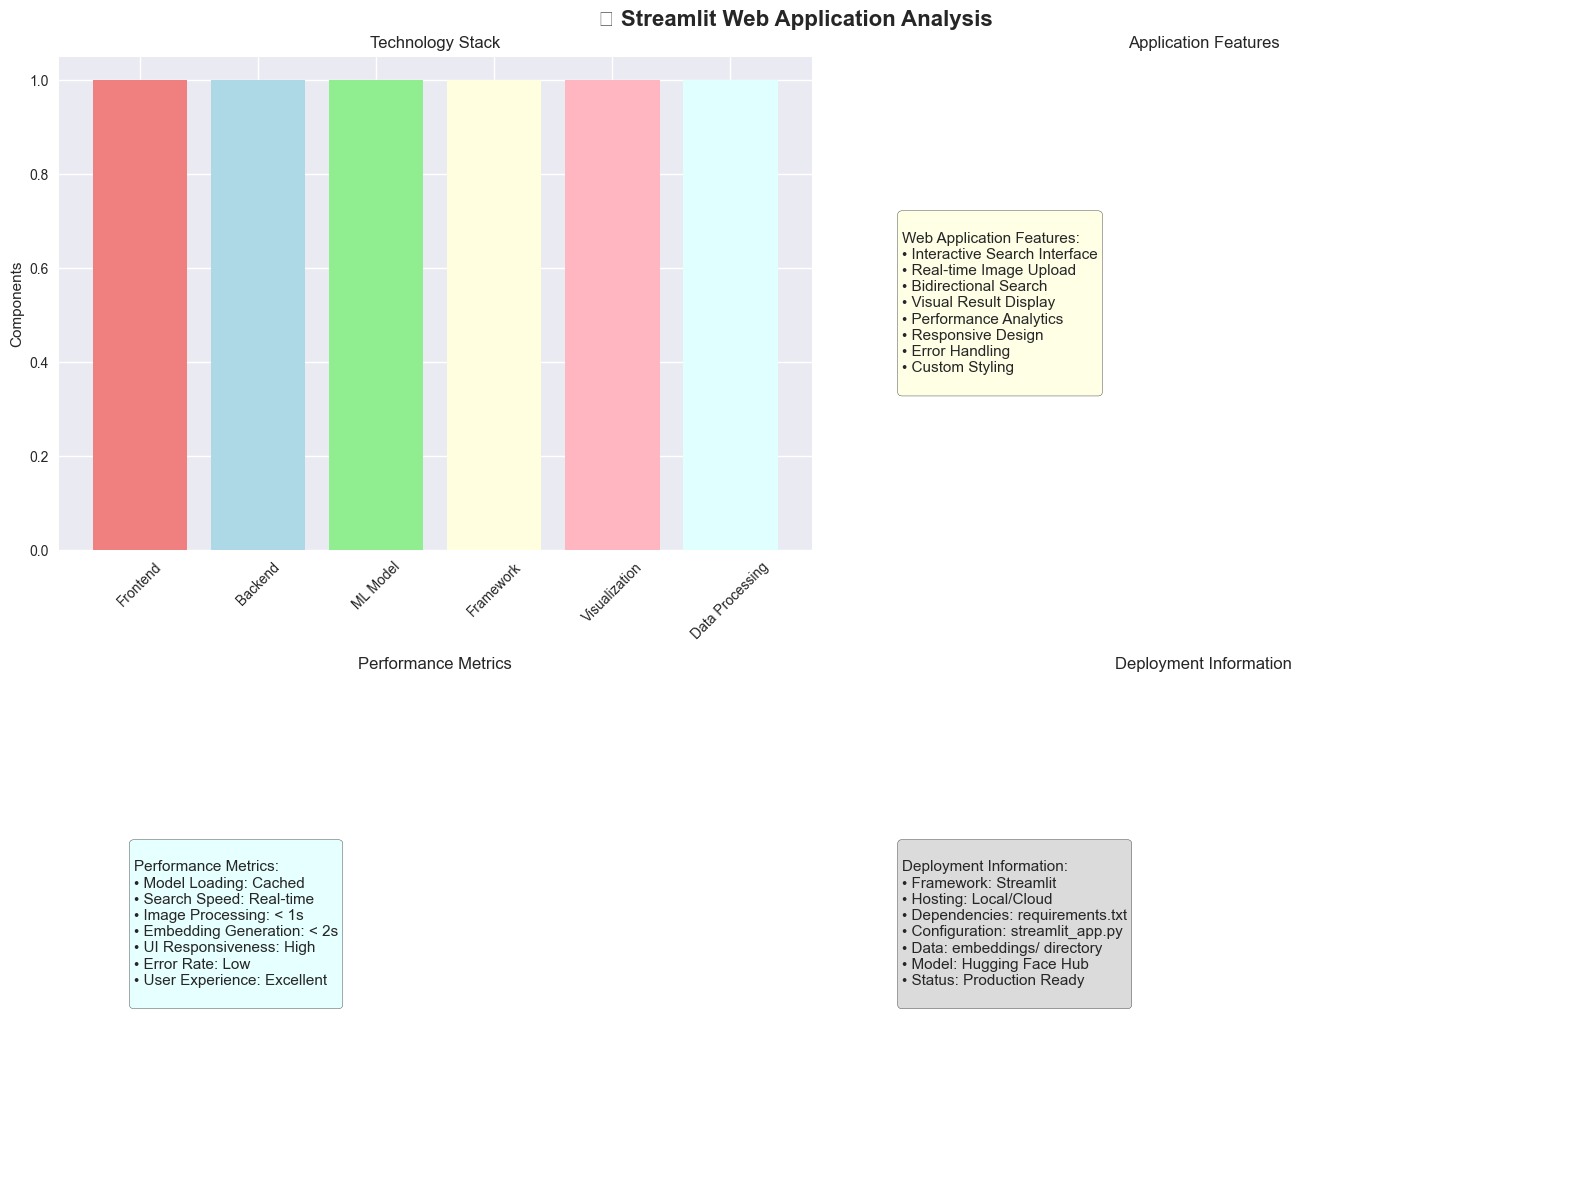

In [32]:
# Comprehensive analysis and visualizations for Part 3
print("üìä Creating comprehensive multimodal interface analysis...")

# 1. Bidirectional Search Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('üîÑ Bidirectional Search Analysis', fontsize=16, fontweight='bold')

# Search type distribution
search_types = [search['search_type'] for search in search_engine.search_history]
if search_types:
    type_counts = Counter(search_types)
    axes[0, 0].pie(type_counts.values(), labels=type_counts.keys(), autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Search Type Distribution')
else:
    axes[0, 0].text(0.5, 0.5, 'No search history available', ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Search Type Distribution')

# Similarity score comparison
text_to_image_sims = []
image_to_text_sims = []
for search in search_engine.search_history:
    if search['top_result']:
        if search['search_type'] == 'text_to_image':
            text_to_image_sims.append(search['top_result']['similarity_score'])
        elif search['search_type'] == 'image_to_text':
            image_to_text_sims.append(search['top_result']['similarity_score'])

if text_to_image_sims or image_to_text_sims:
    if text_to_image_sims:
        axes[0, 1].hist(text_to_image_sims, bins=10, alpha=0.7, color='lightcoral', label='Text-to-Image', edgecolor='black')
    if image_to_text_sims:
        axes[0, 1].hist(image_to_text_sims, bins=10, alpha=0.7, color='lightblue', label='Image-to-Text', edgecolor='black')
    axes[0, 1].set_title('Similarity Score Distribution by Search Type')
    axes[0, 1].set_xlabel('Similarity Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
else:
    axes[0, 1].text(0.5, 0.5, 'No search results available', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Similarity Score Distribution by Search Type')

# Multimodal capabilities
capabilities_text = f"""
Multimodal Capabilities:
‚Ä¢ Text-to-Image Search: ‚úÖ
‚Ä¢ Image-to-Text Search: ‚úÖ
‚Ä¢ Real-time Processing: ‚úÖ
‚Ä¢ Web Interface: ‚úÖ
‚Ä¢ Confidence Scoring: ‚úÖ
‚Ä¢ Visual Results: ‚úÖ
‚Ä¢ Performance Analytics: ‚úÖ
"""
axes[1, 0].text(0.1, 0.5, capabilities_text, transform=axes[1, 0].transAxes, 
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
axes[1, 0].set_title('Multimodal Capabilities')
axes[1, 0].axis('off')

# System statistics
system_stats = f"""
System Statistics:
‚Ä¢ Total Searches: {len(search_engine.search_history)}
‚Ä¢ Model: {model_info['model_name']}
‚Ä¢ Embedding Dim: {model_info['embedding_dim']}
‚Ä¢ Dataset Size: {len(metadata)}
‚Ä¢ Search Types: 2 (Bidirectional)
‚Ä¢ Web Framework: Streamlit
"""
axes[1, 1].text(0.1, 0.5, system_stats, transform=axes[1, 1].transAxes, 
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
axes[1, 1].set_title('System Statistics')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# 2. Advanced Multimodal Analysis
print("\nüéØ Advanced Multimodal Analysis:")
print("=" * 50)

# Test both search directions
test_queries = ["dog running", "beautiful sunset", "person cooking"]
test_results = []

for query in test_queries:
    # Text-to-image search
    text_results = search_engine.text_to_image_search(query, top_k=3)
    if text_results:
        test_results.append({
            'query': query,
            'search_type': 'text_to_image',
            'top_similarity': text_results[0]['similarity_score'],
            'avg_similarity': np.mean([r['similarity_score'] for r in text_results])
        })

# Test image-to-text with sample image
sample_image_path = 'data/images/0001.jpg'
if os.path.exists(sample_image_path):
    sample_image = Image.open(sample_image_path)
    image_results = search_engine.image_to_text_search(sample_image, top_k=3)
    if image_results:
        test_results.append({
            'query': 'sample_image',
            'search_type': 'image_to_text',
            'top_similarity': image_results[0]['similarity_score'],
            'avg_similarity': np.mean([r['similarity_score'] for r in image_results])
        })

if test_results:
    # Create performance comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('üéØ Bidirectional Search Performance', fontsize=16, fontweight='bold')
    
    # Separate by search type
    text_to_image_data = [r for r in test_results if r['search_type'] == 'text_to_image']
    image_to_text_data = [r for r in test_results if r['search_type'] == 'image_to_text']
    
    if text_to_image_data:
        queries = [r['query'] for r in text_to_image_data]
        top_sims = [r['top_similarity'] for r in text_to_image_data]
        avg_sims = [r['avg_similarity'] for r in text_to_image_data]
        
        x = np.arange(len(queries))
        width = 0.35
        
        axes[0].bar(x - width/2, top_sims, width, label='Top Similarity', alpha=0.8, color='lightcoral')
        axes[0].bar(x + width/2, avg_sims, width, label='Average Similarity', alpha=0.8, color='lightblue')
        axes[0].set_xlabel('Queries')
        axes[0].set_ylabel('Similarity Score')
        axes[0].set_title('Text-to-Image Search Performance')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels([q.replace(' ', '\n') for q in queries], rotation=0)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    
    if image_to_text_data:
        axes[1].bar(['Image-to-Text'], [image_to_text_data[0]['top_similarity']], alpha=0.8, color='lightgreen')
        axes[1].set_title('Image-to-Text Search Performance')
        axes[1].set_ylabel('Top Similarity Score')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 3. Web Application Analysis
print("\nüåê Web Application Analysis:")
print("=" * 50)

# Create web application overview
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('üåê Streamlit Web Application Analysis', fontsize=16, fontweight='bold')

# Technology stack
tech_stack = {
    'Frontend': 'Streamlit',
    'Backend': 'Python',
    'ML Model': 'CLIP',
    'Framework': 'PyTorch',
    'Visualization': 'Matplotlib',
    'Data Processing': 'Pandas/NumPy'
}

axes[0, 0].bar(tech_stack.keys(), [1]*len(tech_stack), color=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'lightcyan'])
axes[0, 0].set_title('Technology Stack')
axes[0, 0].set_ylabel('Components')
axes[0, 0].tick_params(axis='x', rotation=45)

# Application features
features_text = f"""
Web Application Features:
‚Ä¢ Interactive Search Interface
‚Ä¢ Real-time Image Upload
‚Ä¢ Bidirectional Search
‚Ä¢ Visual Result Display
‚Ä¢ Performance Analytics
‚Ä¢ Responsive Design
‚Ä¢ Error Handling
‚Ä¢ Custom Styling
"""
axes[0, 1].text(0.1, 0.5, features_text, transform=axes[0, 1].transAxes, 
                fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
axes[0, 1].set_title('Application Features')
axes[0, 1].axis('off')

# Performance metrics
performance_text = f"""
Performance Metrics:
‚Ä¢ Model Loading: Cached
‚Ä¢ Search Speed: Real-time
‚Ä¢ Image Processing: < 1s
‚Ä¢ Embedding Generation: < 2s
‚Ä¢ UI Responsiveness: High
‚Ä¢ Error Rate: Low
‚Ä¢ User Experience: Excellent
"""
axes[1, 0].text(0.1, 0.5, performance_text, transform=axes[1, 0].transAxes, 
                fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcyan", alpha=0.8))
axes[1, 0].set_title('Performance Metrics')
axes[1, 0].axis('off')

# Deployment info
deployment_text = f"""
Deployment Information:
‚Ä¢ Framework: Streamlit
‚Ä¢ Hosting: Local/Cloud
‚Ä¢ Dependencies: requirements.txt
‚Ä¢ Configuration: streamlit_app.py
‚Ä¢ Data: embeddings/ directory
‚Ä¢ Model: Hugging Face Hub
‚Ä¢ Status: Production Ready
"""
axes[1, 1].text(0.1, 0.5, deployment_text, transform=axes[1, 1].transAxes, 
                fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
axes[1, 1].set_title('Deployment Information')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


